# Import Libraries

In [45]:
import tweepy
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import multiprocessing

import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

from sklearn.cluster import KMeans
from wordcloud import WordCloud

from time import time

# Parse tweets

In [22]:
consumer_key = " "
consumer_secret = " "
access_token = " "
access_token_secret = " "

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

file = open('nsl.csv', 'w',encoding='utf-8')
csvWriter = csv.writer(file)
for tweet in tweepy.Cursor(api.search,q="#nationalsecuritylaw",lang="en", count = 50000, since="2020-07-30").items():
    csvWriter.writerow([tweet.created_at, tweet.text])
file.close()

data = pd.read_csv("nsl.csv", header = None, encoding='utf-8', names = ['Time', 'Tweets'])

## Data cleaning

In [27]:
#removing hashtags
def rem_hashtags(text):
    processed_text = re.sub(r"#nationalsecuritylaw", "", text)
    processed_text = " ".join(processed_text.split())
    return processed_text
data['Tweets'] = data['Tweets'].apply(lambda x:rem_hashtags(x))

#removing retweets
def rem_hashtags(text):
    processed_text = re.sub(r"rt", "", text)
    processed_text = " ".join(processed_text.split())
    return processed_text
data['Tweets'] = data['Tweets'].apply(lambda x:rem_hashtags(x))

#removing tagged users from the tweets
def remove_users(text):
    processed_text = re.sub(r'@\w+ ?',"",text)
    processed_text = " ".join(processed_text.split())
    return processed_text
data['Tweets'] = data['Tweets'].apply(lambda x:remove_users(x))

#removing hyperlinks mentioned in the tweets
def remove_links(text):
    processed_text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    processed_text = " ".join(processed_text.split())
    return processed_text
data['Tweets'] = data['Tweets'].apply(lambda x:remove_links(x))

#removing punctuations in the tweets
def remove_punct(text):
    punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text  = "".join([char for char in text if char not in punctuations])
    text = re.sub('[0-9]+', '', text)
    return text
data['Tweets'] = data['Tweets'].apply(lambda x: remove_punct(x))

#making all tweets lowercase
def lowercase_word(text):
    text  = "".join([char.lower() for char in text])
    return text
data['Tweets'] = data['Tweets'].apply(lambda x: lowercase_word(x))

6566

## Wordcloud

(-0.5, 399.5, 199.5, -0.5)

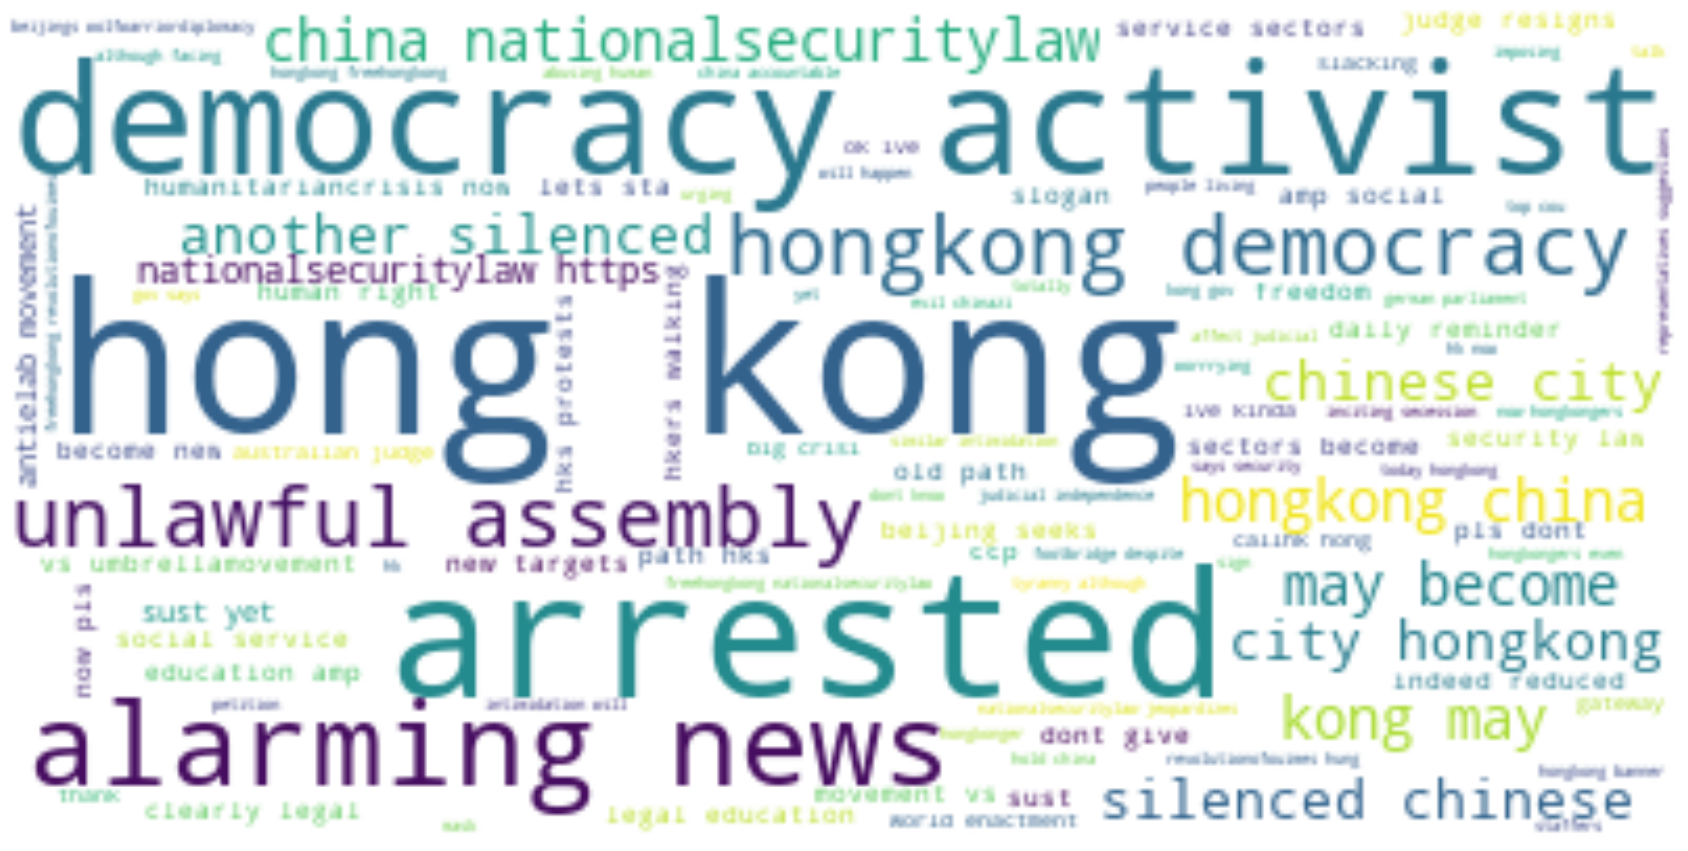

In [28]:
tweet_All = " ".join(tweet for tweet in data['Tweets'])
fig, ax = plt.subplots(1, 1, figsize  = (30,30))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.axis('off')

# Word embedding

In [36]:
file_cleaned = data.dropna().drop_duplicates().reset_index(drop=True)
file_cleaned

,Time,Tweets
0,2020-09-29 02:58:36,this is how hong kong’s nationalsecuritylaw si...
1,2020-09-29 02:49:18,this is how hong kong’s nationalsecuritylaw si...
2,2020-09-29 02:46:47,🇩🇪sign this petition on urging the german parl...
3,2020-09-29 02:37:49,hurray this is the saddest win i have ever had...
4,2020-09-29 02:36:09,how much do you understand about the impact an...
...,...,...
6547,2020-09-20 04:39:44,agreed ccp amp hong kong govt suppress freedom...
6548,2020-09-20 04:31:24,…
6549,2020-09-20 04:08:54,first judge resigns amid appalled to hear that...
6550,2020-09-20 04:05:37,first judge resigns amid appalled to hear that...


In [62]:
file_model = file_cleaned

In [73]:
sent = [row for row in file_model['Tweets']]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
len(sentences)

6552

In [85]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)
start = time()
w2v_model.build_vocab(sentences, progress_per=100)
print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))
w2v_model.corpus_count

Time to build vocab: 0.0 mins


6552

In [94]:
start = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=1000, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))
w2v_model.init_sims(replace=True)

Time to train the model: 0.95 mins


# K-means clustering

In [95]:
word_vectors = w2v_model.wv

In [96]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
word_vectors.similar_by_vector(model.cluster_centers_[0], topn=10, restrict_vocab=None)

[('👿', 0.6057190299034119),
 ('‼', 0.5872328877449036),
 ('w', 0.568162202835083),
 ('k', 0.5464901924133301),
 ('🌍', 0.5365990400314331),
 ('y', 0.5349817872047424),
 ('👎', 0.5296245217323303),
 ('👇', 0.5181576609611511),
 ('😱', 0.5177445411682129),
 ('🏼', 0.5088444948196411)]

In [97]:
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

In [98]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors.wv[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

/home/auyongcs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [101]:
words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [103]:
words['words']

0     t
1     h
2     i
3     s
4      
     ..
58    🌏
59    🇭
60    🇰
61    🌍
62    👎
Name: words, Length: 63, dtype: object

# To do: Fix the word length (63 is weird); assign cluster